In [33]:
using RxInferClientOpenAPI
using Plots, Statistics

In [34]:
module Environment 
using Plots

Base.@kwdef struct Drone
    gravity::Float64
    mass::Float64
    inertia::Float64
    radius::Float64
    force_limit::Float64
end

get_gravity(drone::Drone) = drone.gravity
get_mass(drone::Drone) = drone.mass
get_inertia(drone::Drone) = drone.inertia
get_radius(drone::Drone) = drone.radius
get_force_limit(drone::Drone) = drone.force_limit

get_properties(drone::Drone) =
    (get_gravity(drone), get_mass(drone), get_inertia(drone), get_radius(drone), get_force_limit(drone))

function state_transition(state, actions, drone::Drone, dt)

    # extract drone properties
    g, m, I, r, limit = get_properties(drone)
    
    # extract feasible actions
    Fl, Fr = clamp.(actions, 0, limit)
    
    # extract state properties
    x, y, vx, vy, θ, ω = state
    
    # compute forces and torques
    Fg = m * g
    Fy = (Fl + Fr) * cos(θ) - Fg
    Fx = (Fl + Fr) * sin(θ)
    𝜏  = (Fl - Fr) * r
    
    # compute movements
    ax = Fx / m
    ay = Fy / m
    vx_new = vx + ax * dt
    #     vy_new = vx + ay * dt # old version
    vy_new = vy + ay * dt   # new version
    x_new  = x + vx * dt + ax * dt^2 / 2
    y_new  = y + vy * dt + ay * dt^2 / 2
    
    # compute rotations
    α = 𝜏 / I
    ω_new = ω + α * dt
    θ_new = θ + ω * dt + α * dt^2 / 2
    
    return [x_new, y_new, vx_new, vy_new, θ_new, ω_new]
end

function plot_drone!(p, drone::Drone, state; color = :black)
    x, y, x_a, y_a, θ, ω = state
    _, _, _, radius, _ = get_properties(drone)
    dx = radius * cos(θ)
    dy = radius * sin(θ)

    drone_position = [ x ], [ y ]
    drone_engines  = [ x - dx, x + dx ], [ y + dy, y - dy ]
    drone_coordinates = [ x - dx, x, x + dx ], [ y + dy, y, y - dy ]

    rotation_matrix = [ cos(-θ) -sin(-θ); sin(-θ) cos(-θ) ]
    engine_shape = [ -1 0 1; 1 -1 1 ]
    drone_shape  = [ -2 -2 2 2 ; -1 1 1 -1 ]
    
    engine_shape = rotation_matrix * engine_shape
    drone_shape  = rotation_matrix * drone_shape
    engine_marker = Shape(engine_shape[1, :], engine_shape[2, :])
    drone_marker  = Shape(drone_shape[1, :], drone_shape[2, :])
    
    scatter!(p, drone_position[1], drone_position[2]; color = color, label = false, marker = drone_marker)
    scatter!(p, drone_engines[1], drone_engines[2]; color = color, label = false, marker = engine_marker, ms = 10)
    plot!(p, drone_coordinates; color = color, label = false)

    return p
end
end

Main.Environment

In [35]:
client = RxInferClientOpenAPI.OpenAPI.Clients.Client("http://localhost:8000/v1")
RxInferClientOpenAPI.OpenAPI.Clients.set_header(client, "Authorization", "Bearer dev-token");

In [36]:
server_api = RxInferClientOpenAPI.ServerApi(client)
models_api = RxInferClientOpenAPI.ModelsApi(client);

In [37]:
response, info = RxInferClientOpenAPI.get_server_info(server_api)
response

{
  "rxinfer_version": "4.3.1",
  "server_version": "1.0.0-DEV",
  "server_edition": "CommunityEdition",
  "julia_version": "1.11.4",
  "api_version": "v1"
}


In [38]:
response, info = RxInferClientOpenAPI.get_models(models_api)
response

{
  "models": [
    {
      "name": "BetaBernoulli-v1",
      "description": "A simple Beta-Bernoulli model"
    },
    {
      "name": "Drone2D-v1",
      "description": "A 2D drone model"
    }
  ]
}


In [39]:
drone = Environment.Drone(
    gravity = 9.81,
    mass = 1.0,
    inertia = 1.0,
    radius = 0.2,
    force_limit = 15
)

Main.Environment.Drone(9.81, 1.0, 1.0, 0.2, 15.0)

In [40]:
create_model_req = RxInferClientOpenAPI.CreateModelRequest(
    model = "Drone2D-v1",
    description = "2D drone demonstration",
    arguments = Dict(
        "dt" => 0.05,
        "horizon" => 40,
        "gravity" => drone.gravity,
        "mass" => drone.mass,
        "inertia" => drone.inertia,
        "radius" => drone.radius,
        "force_limit" => drone.force_limit
    )
)

response, _ = RxInferClientOpenAPI.create_model(models_api, create_model_req)
model_id = response.model_id

"cafcb6bf-f76a-453f-b9e6-979fc14dd8b8"

In [41]:
initial_state = [ 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 ]
target = [ 0.4, 0.8 ]

2-element Vector{Float64}:
 0.4
 0.8

In [42]:
inference_req = RxInferClientOpenAPI.InferRequest(
    data = Dict(
        "current_state" => initial_state,
        "target" => target,
    )
)
response, _ = RxInferClientOpenAPI.run_inference(models_api, model_id, inference_req);

In [43]:
states = [ initial_state ]
for action in response.results["actions"]
    a = Float64.(action)
    current_state = last(states)
    next_state = Environment.state_transition(current_state, a, drone, 0.05)
    push!(states, next_state)
end

Plots.AnimatedGif("/Users/bvdmitri/Projects/LazyDynamics/RxInferServer/examples/drone-plan.gif")
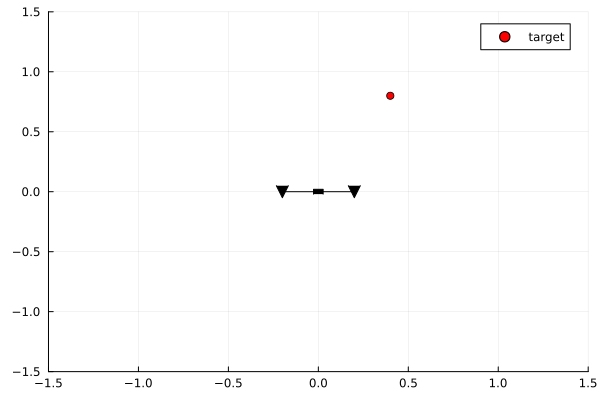

In [44]:
animation = @animate for k in 1:length(states)

    # plot target
    p = scatter([target[1]], [target[2]], label = "target"; color = :red)

    # plot drone
    Environment.plot_drone!(p, drone, states[k])

    xlims!(-1.5, 1.5)
    ylims!(-1.5, 1.5)

end

gif(animation, "drone-plan.gif", show_msg = false)

In [45]:
function experiment_with_server()

    drone = Environment.Drone(
        gravity = 9.81,
        mass = 1.0,
        inertia = 1.0,
        radius = 0.2,
        force_limit = 15
    )

    dt = 0.1
    horizon = 20

    create_model_req = RxInferClientOpenAPI.CreateModelRequest(
        model = "Drone2D-v1",
        description = "2D drone demonstration",
        arguments = Dict(
            "dt" => dt,
            "horizon" => horizon,
            "gravity" => drone.gravity,
            "mass" => drone.mass,
            "inertia" => drone.inertia,
            "radius" => drone.radius,
            "force_limit" => drone.force_limit
        )
    )
    
    response, _ = RxInferClientOpenAPI.create_model(models_api, create_model_req)
    model_id = response.model_id

    targets = [
        [ 0.4, 0.8 ],
        [ -0.4, 0.8 ],
        [ 0.6, 0.0 ],
        [ 0.0, 0.6 ],
    ] 
    
    initial_state = [ 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 ]  

    current_state = copy(initial_state)
    times = Float64[]
    
    animation = @animate for k in 1:150

        target = targets[div(k, 50) + 1]

        start_time = time_ns()
        inference_req = RxInferClientOpenAPI.InferRequest(
            data = Dict(
                "current_state" => current_state,
                "target" => target,
            )
        )
        response, _ = RxInferClientOpenAPI.run_inference(models_api, model_id, inference_req);
        end_time = time_ns()

        push!(times, end_time - start_time)

        first_action = Float64.(response.results["actions"][1])

        next_state = Environment.state_transition(current_state, first_action, drone, dt)
        current_state = copy(next_state)
    
        # plot target
        p = scatter([target[1]], [target[2]], label = "target"; color = :red)
    
        # plot drone
        Environment.plot_drone!(p, drone, next_state)
    
        xlims!(-1.5, 1.5)
        ylims!(-1.5, 1.5)
    
    end
    
    anim = gif(animation, "drone-plan.gif", show_msg = false)

    return anim, times
end

experiment_with_server (generic function with 1 method)

Plots.AnimatedGif("/Users/bvdmitri/Projects/LazyDynamics/RxInferServer/examples/drone-plan.gif")
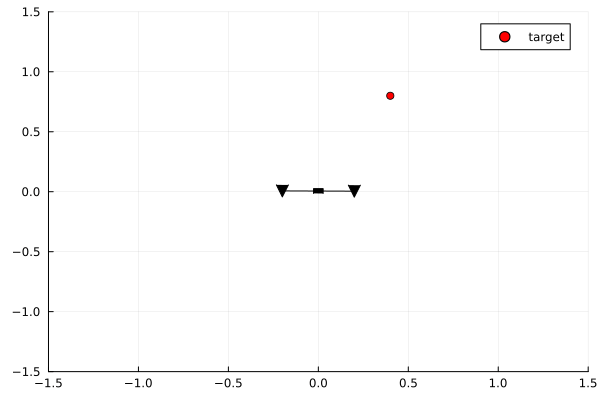

In [46]:
anim, times = experiment_with_server()
anim

In [47]:
times_ms = map(tns -> tns / 10^6, times);

In [48]:
1 / mean(times_ms)

0.07425303463130795